**Libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

import cris_utils as cu
import data_processing as dp
import conv_deconv_blocks as cdb
import cvae_model as md

**Tensorflow GPU Verification**

In [2]:
print("Versión de tensorflow: " + str(tf.__version__))
print("Comprobación de la GPU:",tf.config.experimental.list_physical_devices('GPU'))

Versión de tensorflow: 2.1.0
Comprobación de la GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# CVAE

**Model Arquitecture**

In [3]:
N_H = 28
N_W = 28
N_C = 1

enc_convs = [(32,False,cdb.r_act,3,2),
             (64,False,cdb.r_act,3,2)]

dec_deconvs = [(64,False,cdb.r_act,3,2),
               (32,False,cdb.r_act,3,2),
               (N_C,False,None,3,1)]

n_conv_ls = len(enc_convs)
n_deconv_ls = len(dec_deconvs)

max_layers = cu.max_conv_deconv_layers(N_H)
assert (n_deconv_ls<=max_layers and n_conv_ls<=max_layers), "Incorrect number of layers for generator or discriminator"

config = {
    md.batch_size_k: 100,
    md.latent_dim_k: 50,
    md.adam_alpha_k: 1e-4,
    
    md.checkpoints_folder_k: "./Checkpoints/",
    md.images_folder_k: "./Images/",
    md.max_checkpoints_k: 2
}

enc_config = {
    cdb.input_shape_k: (N_H,N_W,N_C),
    cdb.enc_dec_lys_info_k: enc_convs,
    cdb.enc_fin_den_len_k: 2*config[md.latent_dim_k]
}

hw_f_v = N_H/np.power(2,n_deconv_ls)

dec_config = {
    cdb.dec_den_info_k: ([7,7,32],False,cdb.r_act,(config[md.latent_dim_k],)),
    cdb.enc_dec_lys_info_k: dec_deconvs,
}

for H,W = 28, # deconv layers and # conv layers <= 4 

(# conv layers, heigh,width of last enc volume)
(# deconv layers, heigh,width of first dec volume)
[(1, 14), (2, 7), (3, 3), (4, 1)]


**Data Preparation**

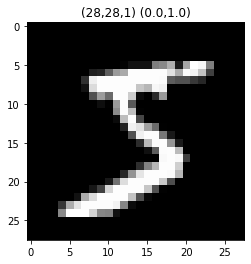

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
#train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
train_images = train_images/255 # Normalize the images to [0, 1]

ti_rs = tf.image.resize(train_images, [N_H, N_W],preserve_aspect_ratio=False)
train_dataset = tf.data.Dataset.from_tensor_slices(ti_rs).batch(config[md.batch_size_k])

l = list(train_dataset.as_numpy_iterator())

cu.imshow(l[0][0,:])

**Creation of Model**

In [5]:
cvae = md.CVAE(enc_config,dec_config,config)

In [6]:
print(cvae.encoder.summary())
print(cvae.decoder.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
re_lu (ReLU)                 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               313700    
Total params: 332,516
Trainable params: 332,516
Non-trainable params: 0
__________________________________________________

**Training Configuration**

In [7]:
train_conf = {
    md.num_epochs_k: 4,
    md.alpha_kl_k: 0.05,
    md.reconstruction_loss_k: md.cross_loss,
    md.dataset_k: train_dataset,
    md.time_measures_k: 1,
    md.create_checkpoints_k: False,
    md.use_latest_checkpoint_k: False,
    md.percent_progress_savings_k: [50,100],
    md.num_images_k: 4
}

**Training**

Time for epoch 1 is 14.5 sec
Time for epoch 2 is 12.2 sec


C:\Users\Y50\Documents\Universidad\Tesis\Codigo\cvae_model.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(num_images,2,1+2*im_index)
C:\Users\Y50\Documents\Universidad\Tesis\Codigo\cvae_model.py:148: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(num_images,2,2*(im_index+1))


Time for epoch 3 is 12.19 sec
Time for epoch 4 is 12.2 sec


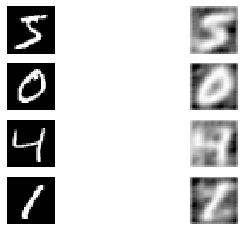

In [8]:
cvae.train(train_conf)

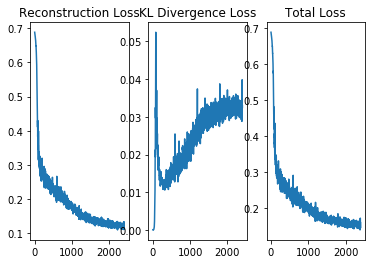

In [9]:
cvae.graph_costs()

**Code Testing**

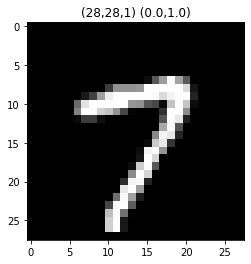

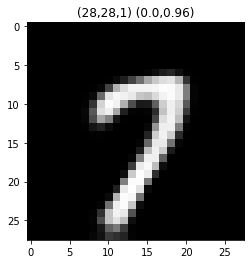

In [10]:
indice = 1
indice2 = 3
_,_,out = cvae.encode_decode_images(l[indice])
cu.imshow(l[indice][indice2,:])
cu.imshow(tf.math.sigmoid(out[indice2,:]).numpy())

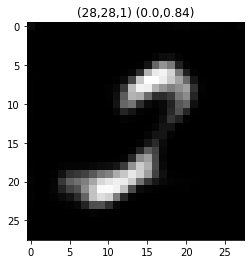

In [16]:
mean_logvar = cvae.encoder(l[indice])
mean, logvar =  tf.split(mean_logvar,2,1)
z = cvae.sampler(mean,logvar)

z = tf.random.normal([100,50])

sam = tf.math.sigmoid(cvae.decoder(z))
    
cu.imshow(sam[indice2,:].numpy())